In [1]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import CoraFull
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import add_self_loops, degree, to_networkx
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Load the dataset
dataset = CoraFull(root='data/CoraFull', transform=NormalizeFeatures())
data = dataset[0]

In [3]:
# Print dataset summary
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_node_features}")
print(f"Number of classes: {data.y.unique().size(0)}")

Data(x=[19793, 8710], edge_index=[2, 126842], y=[19793])
Number of nodes: 19793
Number of edges: 126842
Number of features per node: 8710
Number of classes: 70


In [4]:
data.has_isolated_nodes()

False

In [5]:
# Split the dataset
num_nodes = data.num_nodes
train_idx, test_idx = train_test_split(
    range(num_nodes), test_size=0.2, stratify=data.y)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.25, stratify=data.y[train_idx])

In [6]:
# Create masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

In [7]:
# Feature reduction using PCA
#pca = PCA(n_components=128)  # You can adjust n_components here
#reduced_features = pca.fit_transform(data.x.numpy())
#data.x = torch.tensor(reduced_features, dtype=torch.float)

In [8]:
# Encode labels
encoder = LabelEncoder()
data.y = torch.tensor(encoder.fit_transform(data.y.numpy()), dtype=torch.long)

In [9]:
writer = SummaryWriter(log_dir='runs/gcn_experiment')

In [10]:
# Define GCN Layers with Batch Normalization
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [11]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

        # Batch Normalization after each GCN layer
        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.bn1(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        x = self.bn2(x)
        return F.log_softmax(x, dim=1)

In [12]:
# Prepare the adjacency matrix
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
deg = degree(edge_index[0], num_nodes=data.num_nodes)
deg_inv_sqrt = deg.pow(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
row, col = edge_index
adj_norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
adj_norm = torch.sparse_coo_tensor(edge_index, adj_norm, (data.num_nodes, data.num_nodes))

In [13]:
# Model initialization
model = GCN(
    nfeat=data.x.size(1),
    nhid=256,  
    nclass=data.y.max().item() + 1,
    dropout=0.5  
)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [14]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Weighted Cross-Entropy Loss for handling class imbalance
class_weights = data.y.bincount().float()
class_weights = 1.0 / class_weights
class_weights = class_weights / class_weights.sum()
loss_fn = nn.NLLLoss(weight=class_weights)

In [15]:
# Early Stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_without_improvement = 0

In [16]:
# Training and evaluation loop
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double().sum()
    return correct / len(labels)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [17]:
# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, adj_norm)
    loss_train = loss_fn(output[data.train_mask], data.y[data.train_mask])
    acc_train = accuracy(output[data.train_mask], data.y[data.train_mask])
    train_losses.append(loss_train.item())
    train_accuracies.append(acc_train.item())
    loss_train.backward()
    optimizer.step()

    model.eval()
    output = model(data.x, adj_norm)
    loss_val = loss_fn(output[data.val_mask], data.y[data.val_mask])
    acc_val = accuracy(output[data.val_mask], data.y[data.val_mask])
    val_losses.append(loss_val.item())
    val_accuracies.append(acc_val.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss {loss_train.item():.4f}, Val Loss {loss_val.item():.4f}, Train Acc {acc_train:.4f}, Val Acc {acc_val:.4f}")
    
    # Log metrics to TensorBoard
    writer.add_scalar('Loss/train', loss_train.item(), epoch)
    writer.add_scalar('Loss/val', loss_val.item(), epoch)
    writer.add_scalar('Accuracy/train', acc_train.item(), epoch)
    writer.add_scalar('Accuracy/val', acc_val.item(), epoch)
    
    # Early Stopping
    #if loss_val < best_val_loss:
        #best_val_loss = loss_val
        #epochs_without_improvement = 0
    #else:
        #epochs_without_improvement += 1
        #if epochs_without_improvement >= patience:
            #print("Early stopping triggered")
            #break
    
    # Step the scheduler
    scheduler.step()
    
writer.close()

Epoch 0: Train Loss 4.7699, Val Loss 4.2502, Train Acc 0.0112, Val Acc 0.0129
Epoch 10: Train Loss 2.0098, Val Loss 4.2303, Train Acc 0.5743, Val Acc 0.0141
Epoch 20: Train Loss 1.3618, Val Loss 4.2001, Train Acc 0.6952, Val Acc 0.3382
Epoch 30: Train Loss 1.2025, Val Loss 4.1611, Train Acc 0.7232, Val Acc 0.5165
Epoch 40: Train Loss 1.0775, Val Loss 4.0967, Train Acc 0.7450, Val Acc 0.6067
Epoch 50: Train Loss 1.0205, Val Loss 3.9900, Train Acc 0.7583, Val Acc 0.6560
Epoch 60: Train Loss 0.9758, Val Loss 3.8117, Train Acc 0.7647, Val Acc 0.6742
Epoch 70: Train Loss 0.9482, Val Loss 3.5221, Train Acc 0.7652, Val Acc 0.6769
Epoch 80: Train Loss 0.9270, Val Loss 3.0831, Train Acc 0.7702, Val Acc 0.6787
Epoch 90: Train Loss 0.9130, Val Loss 2.5260, Train Acc 0.7749, Val Acc 0.6797
Epoch 100: Train Loss 0.9049, Val Loss 2.0372, Train Acc 0.7793, Val Acc 0.6787
Epoch 110: Train Loss 0.8978, Val Loss 1.7662, Train Acc 0.7803, Val Acc 0.6787
Epoch 120: Train Loss 0.8927, Val Loss 1.6590, Trai

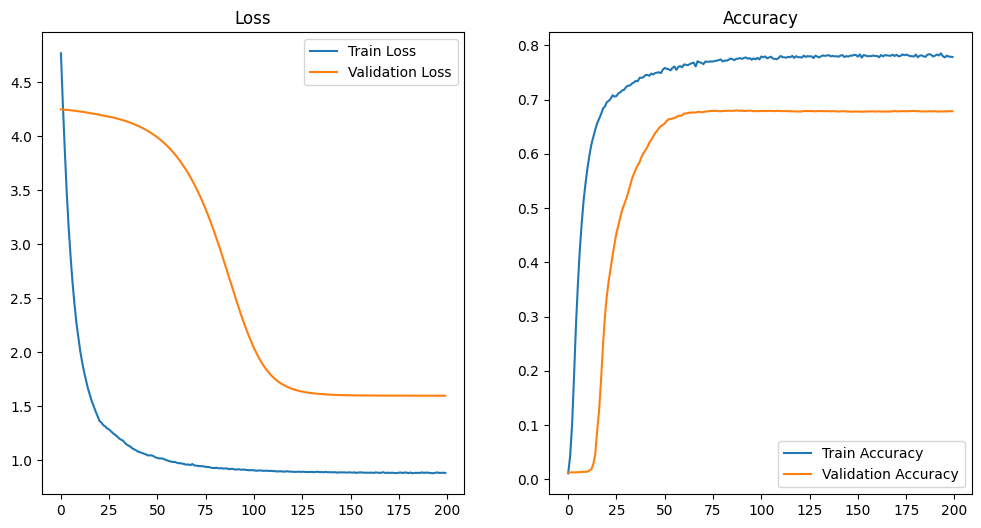

In [18]:
# Plot learning curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [19]:
# Test evaluation
model.eval()
output = model(data.x, adj_norm)
test_loss = loss_fn(output[data.test_mask], data.y[data.test_mask])
test_acc = accuracy(output[data.test_mask], data.y[data.test_mask])
print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.5152, Test Accuracy: 0.6812


In [20]:
# Generate classification report and confusion matrix
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = output[data.test_mask].max(1)[1].cpu().numpy()
report = classification_report(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79        51
           1       0.44      0.80      0.57        10
           2       0.74      0.59      0.66        49
           3       0.74      0.71      0.72        76
           4       0.90      0.69      0.78        13
           5       0.77      0.90      0.83        61
           6       0.92      0.75      0.83        81
           7       0.70      0.41      0.52       133
           8       0.76      0.85      0.80        48
           9       0.81      0.79      0.80        68
          10       0.45      0.68      0.54        28
          11       0.57      0.67      0.61        45
          12       0.38      0.60      0.46        20
          13       0.76      0.65      0.70       104
          14       0.78      0.76      0.77        68
          15       0.42      0.57      0.48        28
          16       0.47      0.87      0.61        23
   